# Appendix D. AutoDiff

## Manual Differentiation
* **For the function $f(x, y) = x^2 y + y + 2 $,in order to find the derivatives, you just need to use five rules:**
    1. **The derivative of a constant is 0**
    1. **The drivatioe of $\lambda x $ is $\lambda$(where $\lambda$ is a constant)**
    1. **The deriative of $x^{\lambda} $ is $\lambda x^{\lambda - 1}$**
    1. **The derivative of a sum of functions is the sum of these function's derivatives.**
    1. **The derivative of** $\lambda$ **times a function is** $\lambda$ **times its derivatives.**
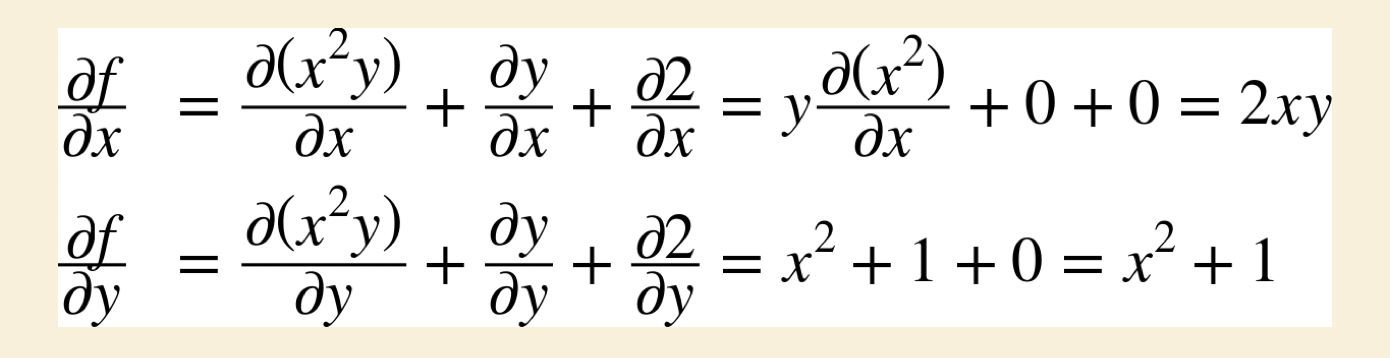

* **This approach can become very tedious for more complex functions.**

## Finite Difference Approximation
* **The derivative $h^{'}(x_0) $ f a function $h(x)$ at a point $x_0$ is the slope of the function at that point.**
    * **The derivative is defined as the limit of the slope of a straight line going through this point $x_0$ and another point $x$ on the function, as $x$ gets infinitely close to $x_0$.**
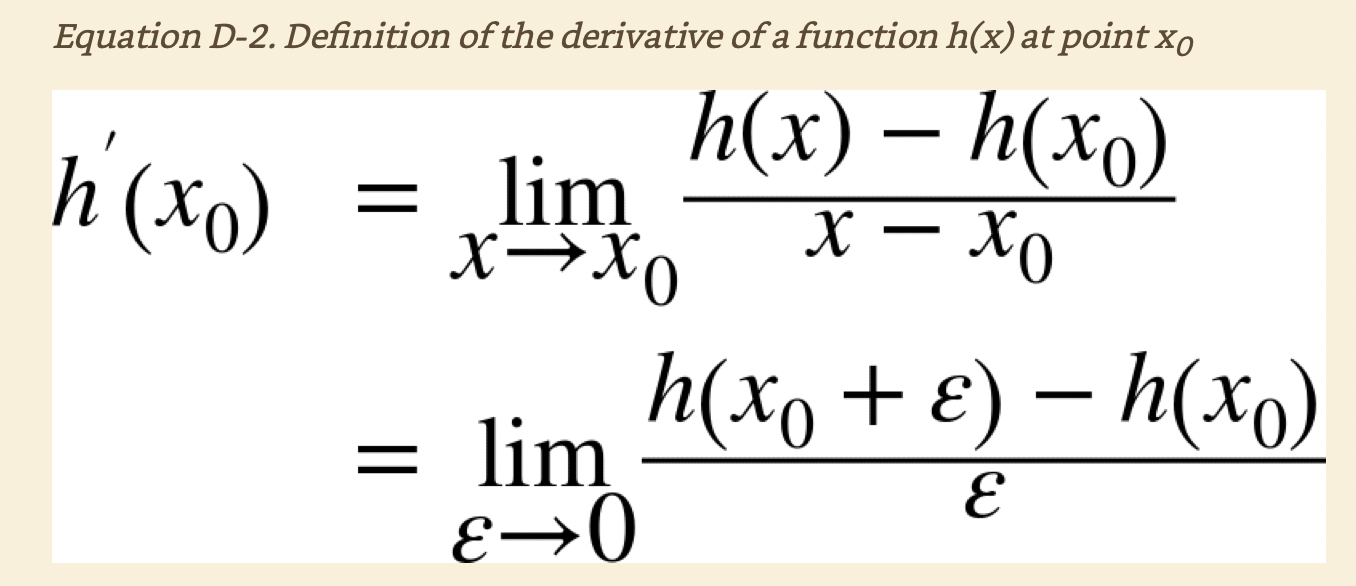

* **If we waned to calculate the partial derivative of $f(x,y)$ with regard to $x$ at $x=3$ and $y=4$, we could compute $f(3+\varepsilon, 4) - f(3, 4)$ and divide the result by $\varepsilon$, using a very small value for $\varepsilon$. This type of numerical approximation of the derivative is called a *finite diference approximation*, and this specific equation is called *Newton's difference quotient*.**

In [1]:
def f(x, y):
    return x**2*y + y + 2

def derivative(f, x, y, x_eps, y_eps):
    return (f(x + x_eps, y + y_eps) - f(x, y)) / (x_eps + y_eps)

df_dx = derivative(f, 3, 4, 0.00001, 0)
df_dy = derivative(f, 3, 4, 0, 0.00001)

**The result is imprecise**

In [2]:
print(df_dx) # correct result is 24

24.000039999805264


In [3]:
print(df_dy) # correct result is 10

10.000000000331966


* **When dealing with large neural networks, finite difference approximation is way too inefficient.**
* **This method is simple to implement.**

## Forward Model Autodiff
$$ g(x, y) = 5 + xy $$
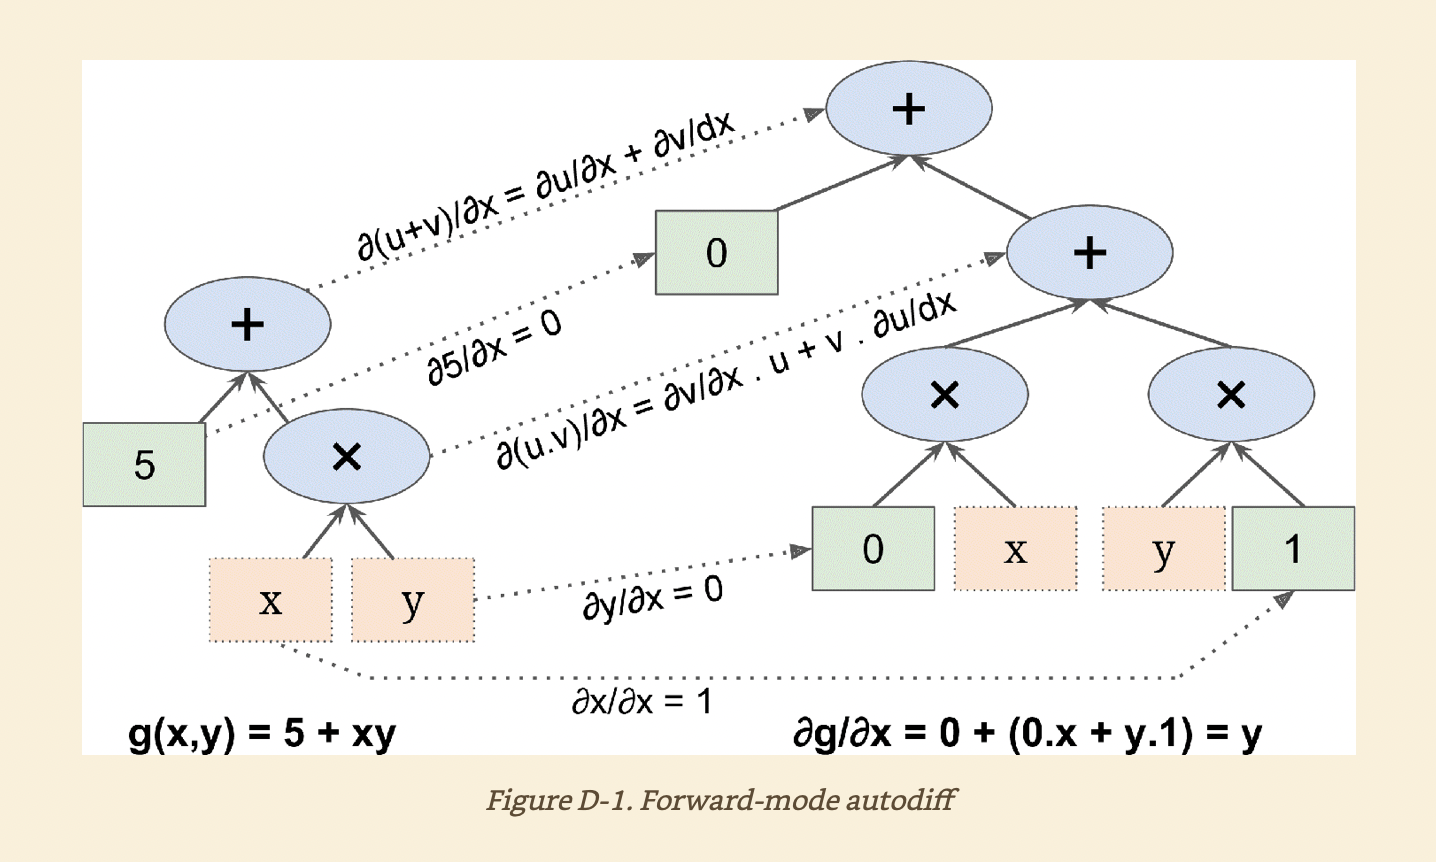
* **The graph for that function is represented on th left.**
* **After forward-mode autodiff, we get the graph on the right, which represents the partial derivative $ \partial g / \partial x = 0 + ( 0 \times x + y \times 1) = y $(we could similary obtain the partial derivative with regard to y)**

* **The algorithm will go through the computation graph from the inputs to the outputs.**
* **We started with a computation graph, and forward-mode autodiff produced another computation graph. This is called *symbolic differentiation*, and it has two nice featutes.**
    * **We  can use it as many times as we ant to compute the derivatives of the given function for any value of x and y.**
    * **we can run forward-mode autodiff again on the resulting graph to get second-order derivatives if we ever need to**

* **It is also possible to run forwar-mode autodiff without constructing a graph(i.e., numerically, not symbolicaly), just by computing intermediate results on the fly.**

##### dual numbers
* **One way to do this is to use *dual numbers*, which has the form $a + b \varepsilon$, where *a* and *b* are real numbers and $\varepsilon$ is an infinitesimal numer such taht $ \varepsilon^2 = 0$(but $\varepsilon \neq 0$ )**
* **A dual number is represented in memory as a pair of floats. For example, $42 + 24 \varepsilon $ is represented by the pair $(42.0, 24.0)$.**
* **Dual numbers can be added, multiplied, and so on.**

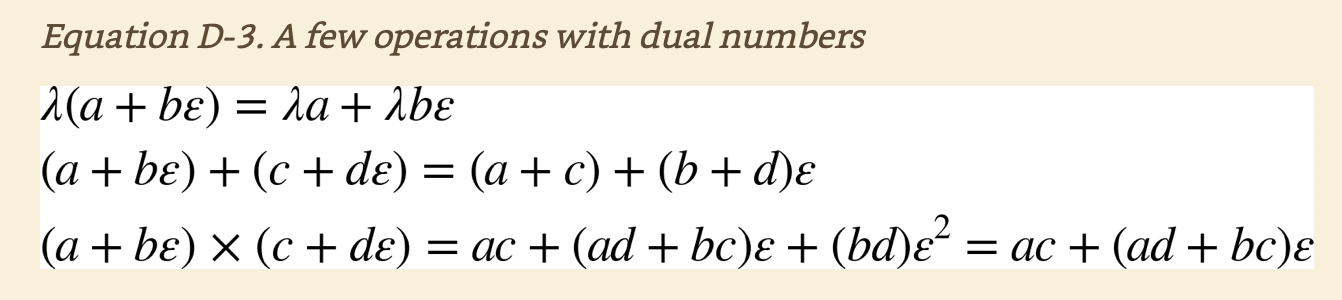

* **It can be shown that $h(a + b \varepsilon) = h(a) + b \times h'(a) \epsilon$, so computing $ h(a + \varepsilon) $ gives you both $h(a) $ and the deriavtive $h^{'}(a) $ in just one shot.**

* **To compute the partial derivatie of $f(x,y) $ with regard to $x$ at $x=3$ and $y=4$(which we will write $\partial f / \partial x (3, 4) $ can computed using dual numbers. All we need to do is compute $f(3 + \varepsilon, 4)$; this will output a dual number whose first component is equal to $f(3,4) $ and whose second component is equal to $\partial f / \partial x (3, 4)$**
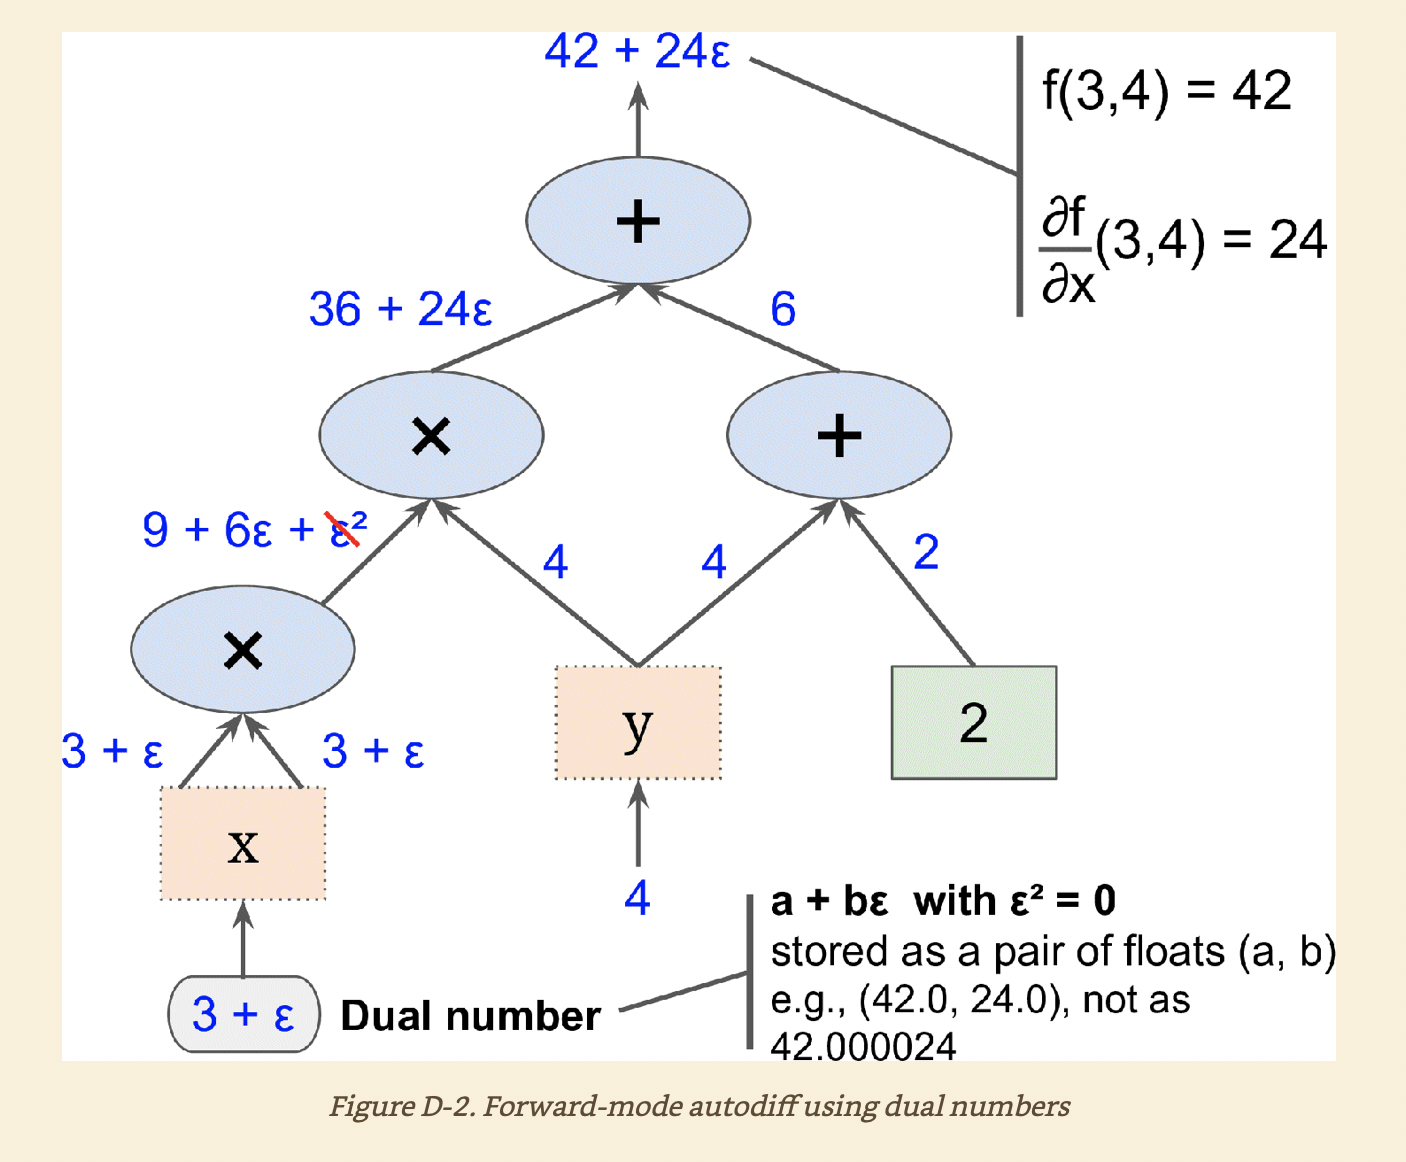

* **To compute $ \partial f / \partial y (3, 4) $ we would have to go  through the graph again, but this time with $x = 3$ and $y = 4 + \varepsilon$**<br>

***Forward-mode autodiff is much more accurate than finite differene approximation, but it suffers from the same major flaw, at least when there are many inputs and few outputs: if there were 1,000 parameters, it would require 1,000 pases through the graph to compute all the partial derivatives.***

## Reverse-Mode Autodiff
* **Reverse-mode autodiff first goes through the graph in the forward direction(i.e., from the inputs to the output) to compute the value of each node**
* **Then it does a second pass, this time in the reverse direction(i.e., form the output to the inputs), to compute all the partial derivatives.**

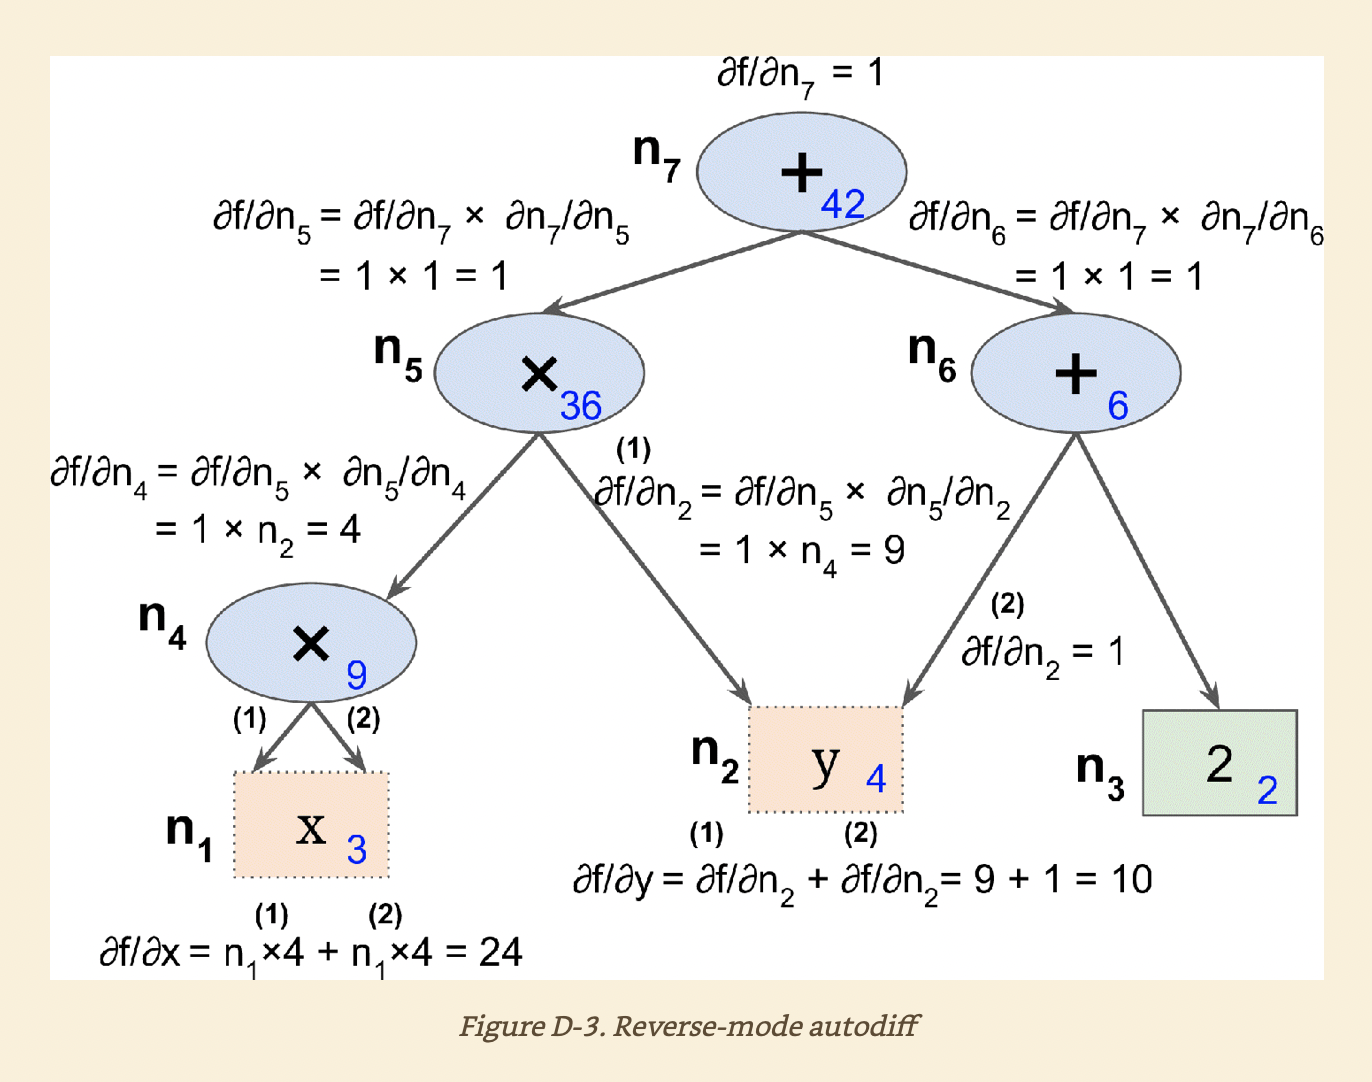

* **During the first pass, all the node values were computed, starting from $x=3$ and $y=4$(the values are at the bottom right of each node.**
* **The idea is to gradually go down the graph, computing the partial derivatie of $f(x,y)$ with regard to each consecutive node, until we reach the variable nodes**

    * **node 7: Since $n_7$ is the output node, $f = n_7$ so $ \partial f / \partial n_7 = 1$**
    * **node 5: Since $\partial f / \partial n_5 = \partial f / \partial n_7 \times \partial n_7 / \partial n_5 $, we already know that $\partial f / \partial n_7 = 1$, so we all need is $\partial n_7 / \partial n_5$**
    * **node 5: Since $n_7$ performs the sum $n_5 + n_6$, we find that $\partial n_7 / \partial n_5 = 1$, so $\partial f / \partial n_5 = 1 \times 1 = 1$**
    * **node 4: Since $\partial f / \partial n_5 = \partial f / \partial n_5 \times \partial n_5 / \partial n_4 $, and $n_5 = n_4 \times n_2, $, we find that $\partial n_5 / \partial n_4 = n_2$, so $\partial f / \partial n_4 = 1 \times n_2 = 4 $**
    
* **Reverse-mode autodiff relies heavily on the *chain rule***
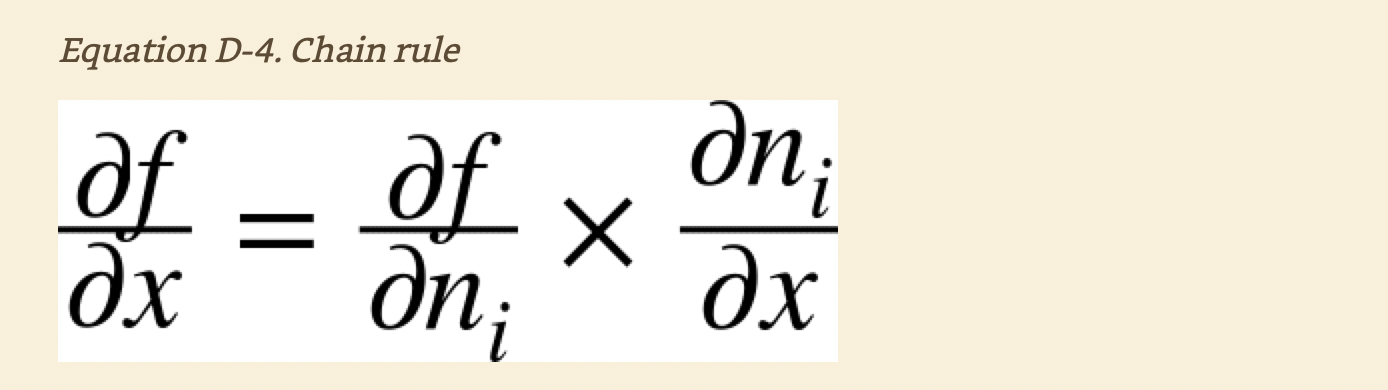



* **Reverse-mode autodiff is a very powerful and accurate technique, especially when there are many inputs and few outputs, since it requires one forward pass plus one reverse pass per output to compute all the partial derivatives for all outputs with regard to all the inputs.**
* **Tensoflow creates a new computation graph: it implements *symbolic* reerse-mode autodiff.**
    * **The computation graph to compute the gradients of the loss with regard to all the parameters in the neural netowrk only needs to be generated once, and then it can be executed over and over again, whenever the optimizer needs to compute the gradients.**
    * **This makes it possible to compute higher-order derivatives if needed.**